# Potato balances

In this notebook we will use the partial least squares balances to quantify differences between potato cultivars.

In [1]:
import pandas as pd
from statsmodels.sandbox.stats.multicomp import multipletests
from skbio import TreeNode
import seaborn as sns
import matplotlib.pyplot as plt
from gneiss.plot import balance_boxplot, balance_barplots, proportion_plot
from gneiss.util import match

from pls_balances.src.balances import balance_classify, round_balance
import numpy as np
import matplotlib
from biom import load_table
import re
import calour as ca


%matplotlib inline
np.random.seed(0)
#font = {'family' : 'normal'
#        'size'   : 16}

#matplotlib.rc('font', **font)

In [2]:
data_dir = '../data/potato_pls_wip/data'
table_file = '%s/MZMINE-aca8c00d-download_biom-main.biom' % data_dir
metadata_file = '%s/potato_untargeted_metabolomics_metadata.txt' % data_dir

table = load_table(table_file)
table = pd.DataFrame(np.array(table.matrix_data.todense()).T+1,
                     index=table.ids(axis='sample'),
                     columns=table.ids(axis='observation'))
metadata = pd.read_table(metadata_file, index_col=0)

# fix all of the table ids
pattern = re.compile(r'C18p_(\S+)_5ul\S+ Peak area') 
f = lambda x: pattern.findall(x)[0]
table.index = [f(i) for i in table.index]

table, metadata = match(table, metadata)

# set the colors
purple_color = '#A569BD' 
white_color = '#B3B6B7' 
red_color = '#F1948A' 

We'll want to first apply standard PLS to see if there are really obvious patterns.

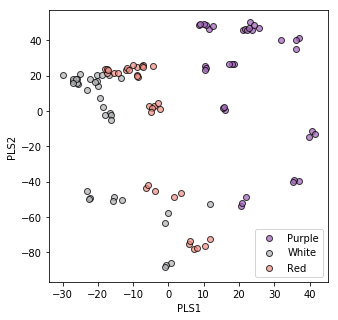

In [3]:
from sklearn.cross_decomposition import PLSRegression
from skbio.stats.composition import clr, centralize, multiplicative_replacement

fig, ax = plt.subplots(figsize=(5, 5))

class_purple = (metadata.cultivar_color == 'Purple').values
class_white = (metadata.cultivar_color == 'White').values
class_red = (metadata.cultivar_color == 'Red').values

Y = np.vstack((class_purple, 
               np.logical_or(class_red, class_white))).astype(np.int).T

potato_pls = PLSRegression(n_components=2)
#table = pd.DataFrame(multiplicative_replacement(table.values),
#                     index=table.index, columns=table.columns
#)
ctable = pd.DataFrame(clr(centralize(table)), 
                      index=table.index, columns=table.columns)

potato_pls.fit(X=ctable.values, Y=Y)

ax.scatter(potato_pls.x_scores_[class_purple, 0], 
           potato_pls.x_scores_[class_purple, 1], 
           color=purple_color, label='Purple', edgecolor='k', marker='o', alpha=0.75)
ax.scatter(potato_pls.x_scores_[class_white, 0], 
           potato_pls.x_scores_[class_white, 1], 
           color=white_color, label='White', edgecolor='k', marker='o', alpha=0.75)
ax.scatter(potato_pls.x_scores_[class_red, 0], 
           potato_pls.x_scores_[class_red, 1], 
           color=red_color, label='Red', edgecolor='k', marker='o', alpha=0.75)
ax.set_xlabel('PLS1')
ax.set_ylabel('PLS2')
ax.legend(loc=4)

As discussed in the horseshoe paper, seeing arch like effects is an indication that we may be seeing maximal separation.

Below, we will fit Gaussian Mixture Models, and see how well they fit.

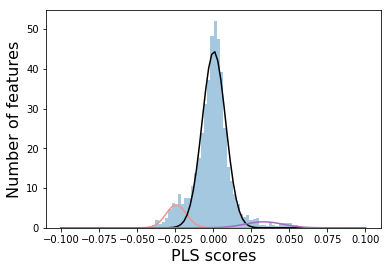

In [4]:
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

fig, ax = plt.subplots(figsize=(6, 4))
potato_pls = PLSRegression(n_components=1)
potato_pls.fit(X=ctable.values, Y=Y)

potato_spectrum = pd.DataFrame(potato_pls.x_weights_, index=ctable.columns, columns=['PLS1'])

potato_mixture = GaussianMixture(n_components=3, 
                                 means_init=np.array([[-0.05], [0], [0.05]]), 
                                 random_state=0)
potato_mixture.fit(X=potato_spectrum.values)

potato_m = np.ravel(potato_mixture.means_)
potato_s = np.ravel(np.sqrt(potato_mixture.covariances_)) 
potato_w = np.ravel(potato_mixture.weights_)

x = np.linspace(-0.1, 0.1, 100)
sns.distplot(potato_spectrum, norm_hist=True, kde=False, ax=ax)
ax.plot(x, potato_w[0]*norm.pdf(x, potato_m[0], potato_s[0]), red_color)
ax.plot(x, potato_w[1]*norm.pdf(x, potato_m[1], potato_s[1]), '-k')
ax.plot(x, potato_w[2]*norm.pdf(x, potato_m[2], potato_s[2]), purple_color)
ax.set_xlabel('PLS scores', fontsize=16)
ax.set_ylabel('Number of features', fontsize=16)
plt.savefig('../results/figures/figure3_potato_feature_histogram.pdf')

Now given what we have seen, it looks like we can fit pretty solid mixture models.  In addition, the purple peak seems very distinct from the red cultivar type.  With this diagnostic information, we'll apply the thresholds and learn a balance that will quantify the separation between the purple and the other cultivars.

In [5]:
l, r = round_balance(potato_spectrum, means_init=np.array([[-0.05], [0], [0.05]]))

denom = potato_spectrum.loc[potato_spectrum.PLS1 < l]
num = potato_spectrum.loc[potato_spectrum.PLS1 > r]

r, s = num.shape[0], denom.shape[0] 
potato_balance = (np.log(table.loc[:, num.index] + 1).mean(axis=1) - 
                  np.log(table.loc[:, denom.index] + 1).mean(axis=1)) * np.sqrt(r*s / (r+s))

Now we will perform cross validation to see how generalizable this model is, by performing 4 fold crossvaliation and calculating the AUROC for the test data set.  Note that this is only an indication of how well this dataset can train the partial least squares balances - if the AUC scores are low, then it is an indication that the dataset is suitable.  This could arise for a number of reasons, but likely due to heterogousity, or sample size.

In [6]:
cats = pd.Series(class_purple, index=metadata.index)
res = balance_classify(table+1, cats, num_folds=4, 
                       means_init=np.array([[-0.05], [0], [0.05]]) )
num, denom, rad_balance, cv = res
cv

,Q2,AUROC
0,-13.0746,1
1,-9.93025,1
2,-27.4606,1
3,-13.4799,1


In [7]:
cv['AUROC'].mean()

1.0

As we can see, the classification accuracy is pretty darn good.  Let's try to visualize the actual separation using histograms.

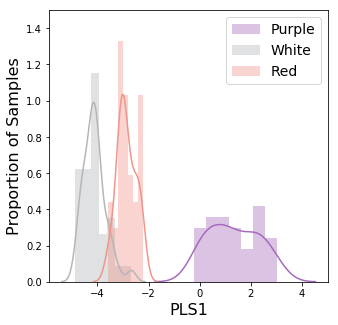

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.distplot(rad_balance[class_purple], 
             label='Purple', color=purple_color, bins=7, ax=ax)
sns.distplot(rad_balance[class_white], 
             label='White', color=white_color, bins=7, ax=ax)
sns.distplot(rad_balance[class_red], 
             label='Red', color=red_color, bins=7, ax=ax)
ax.legend(fontsize=14) 
ax.set_ylabel('Proportion of Samples', fontsize=16)
ax.set_xlabel('PLS1', fontsize=16)
ax.set_ylim([0, 1.5])
plt.savefig('../results/figures/figure3_potato_sample_histogram.pdf')

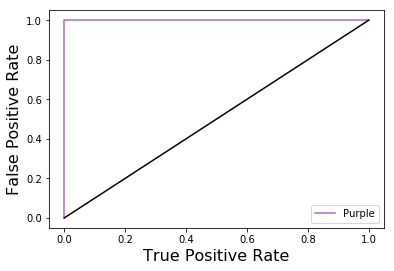

In [9]:
from sklearn.metrics import roc_curve
potato_fpr, potato_tpr, potato_thresholds = roc_curve(y_true=1-cats.astype(int), 
                                                      y_score=rad_balance)

plt.plot(potato_tpr, potato_fpr, label='Purple', c=purple_color)
plt.plot(np.linspace(0, 1), np.linspace(0, 1), c='k')
plt.xlabel('True Positive Rate', fontsize=16)
plt.ylabel('False Positive Rate', fontsize=16)
plt.legend(loc=4)
#plt.savefig('purple_roc_curve.pdf')

In [10]:
from sklearn.metrics import auc
print('Purple vs Others AUC:\t\t', auc(potato_tpr, potato_fpr))

Purple vs Others AUC:		 1.0


In [11]:
from scipy.stats import f_oneway
potato_f, potato_p = f_oneway(potato_balance.loc[class_purple],
                              potato_balance.loc[~class_purple])
print('Purple vs Others \t -- F-statistic: %f \t p-value: \t %E' % (potato_f, potato_p))

Purple vs Others 	 -- F-statistic: 669.906897 	 p-value: 	 2.229118E-47


In [12]:
writer = pd.ExcelWriter('../results/cultivar_color_stats.xlsx')

stats = pd.Series([auc(potato_tpr, potato_fpr), cv['AUROC'].mean(), potato_f, potato_p],
                  index=['AUC', 'AUC_CV', 'F-statistic', 'p-value'])

x = cv['AUROC'].to_excel(writer, sheet_name='cv', index_label='folds')
stats.to_excel(writer, sheet_name='summary', header=False)
writer.save()

In [13]:
import matplotlib

def rgb2hex(x):
    return '#%02x%02x%02x' % (int(x[0]*255), int(x[1]*255), int(x[2]*255))

num = num.sort_values(by='PLS1')
denom = denom.sort_values(by='PLS1')

f_ids = list(num.index) + list(denom.index) + list(set(potato_spectrum.index) - (set(num.index) | set(denom.index)))

n = len(num.index) 
d = len(denom.index)
o = len(f_ids) - n - d

cmap = matplotlib.cm.get_cmap('RdYlBu')
norm = matplotlib.colors.Normalize(vmin=metadata.cultivar_color.min(), 
                                   vmax=metadata.cultivar_color.max())
metadata = metadata.sort_values(by='cultivar_color')
s_ids = list(metadata.index)
potato_colors = pd.Series([purple_color]*metadata.cultivar_color.value_counts()['Purple'] + 
                          [red_color]*metadata.cultivar_color.value_counts()['Red'] + 
                          [white_color]*metadata.cultivar_color.value_counts()['White'],
                          index=s_ids,
                          name='Samples')

feature_colors = pd.Series([purple_color]*n + [white_color]*d + ['#FDFEFE']*o,
                           index=f_ids, name='Features')

In [14]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

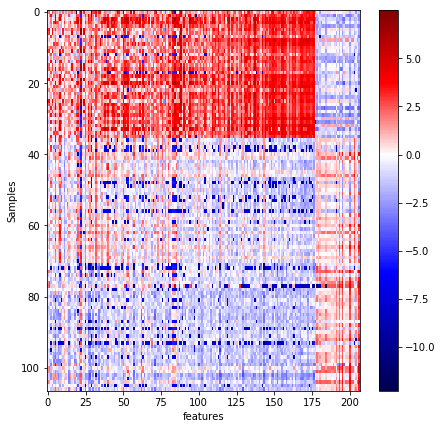

In [15]:
fig = plt.figure(figsize=(7, 7))
ctable = ctable.reindex(columns=f_ids,
                        index=metadata.cultivar_color.sort_values().index)

feature_colors = pd.Series([purple_color]*n + [white_color]*d,
                           index=list(num.index) + list(denom.index), name='Features')
plt.imshow(ctable.loc[:, list(num.index)+list(denom.index)].values,
                      aspect='auto', interpolation='nearest', cmap='seismic', 
                      norm=MidpointNormalize(midpoint=0))
plt.ylabel('Samples')
plt.xlabel('features')
plt.colorbar()

In [24]:
def color_part(x):
    if x in num.index:
        return 'num'
    elif x in denom.index:
        return 'denom'
    else:
        return 'None'
feature_metadata = pd.DataFrame({
    'PLS': potato_spectrum.PLS1,
    'color_part': [color_part(x) for x in potato_spectrum.index]})

In [27]:
table, metadata = match(table, metadata)

In [36]:
exp = ca.experiment.Experiment(data=table.values+1,
                               sample_metadata=metadata, 
                               feature_metadata=feature_metadata)
exp = exp.center_log()

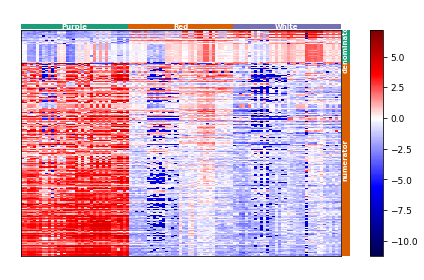

In [37]:
exp2 = exp.filter_by_metadata('color_part', ['numerator', 'denominator'], axis='f')
exp2 = exp2.sort_by_metadata('processing_type', axis='s')
exp2 = exp2.sort_by_metadata('cultivar_color', axis='s')
exp2 = exp2.sort_by_metadata('PLS', axis='f')
exp2 = exp2.sort_by_metadata('color_part', axis='f')

exp2.plot(sample_color_bars=['cultivar_color'], feature_color_bars=['color_part'],
          cmap='seismic', norm=MidpointNormalize(midpoint=0), feature_field=None)

# TODO

We will want to have proportion plots here, with the MS annotations.  From this, we'll also want to pull out the interesting differentiating compounds.